# MCA Assignment_3 
##### Question_1 
#### Jay Rawal  2017240

In [1]:
# Importing "ABC"

import nltk
nltk.download('abc')
from nltk.corpus import abc

[nltk_data] Downloading package abc to
[nltk_data]     C:\Users\Jay\AppData\Roaming\nltk_data...
[nltk_data]   Package abc is already up-to-date!


### Preprocessing

In [2]:
#Ref https://rguigoures.github.io/word2vec_pytorch/

import itertools
import re

def pre_process():
    pre_line = []
    pre_word = []
    
    for temp_words in abc.sents():

        t_words = ' '.join(temp_words).lower()
        t_words.replace('\n'," ")
        text = re.sub('^[a-z]+','',t_words)
        text = re.sub("\.|\'|\,|\-","",text)
        text = re.sub('\"',"",text)
        pre_line.append([w for w in text.split() if w != ''])
        pre_word.extend(pre_line[-1])
        
    return pre_line,pre_word

line_list,word_list = pre_process()

In [3]:
print(len(line_list))
print(len(word_list))

29059
661468


### Sub-sampling

In [4]:
from collections import Counter
import random,math

def subsample(lines,words):
    
    #find ratio of word freq by total
    counts = dict(Counter(words))
    print("Unique words ",len(counts))
    total_words = len(words)
    ratio_dic = {word: counts[word]/float(total_words) for word in counts.keys()}
    
    
    #For each line remove words by probability
    new_lines = []
    for cur_words in lines:
        new_words = []
        for word in cur_words:
            # Subsampling formula from https://rguigoures.github.io/word2vec_pytorch/
            if random.random() < (1+math.sqrt(ratio_dic[word] * 1e3)) * 1e-3 / float(ratio_dic[word]):
                new_words.append(word)       
        new_lines.append(new_words)
    return new_lines,list(counts.keys()),counts


new_lines,word_set,word_dic = subsample(line_list,word_list)

print(len(new_lines))

Unique words  27448
29059


### word->idx and idx->word

In [5]:
word_to_idx = {w: idx for (idx, w) in enumerate(word_set)}
idx_to_word = {idx: w for (idx, w) in enumerate(word_set)}

print(len(word_to_idx))

27448


### Making Windows and Pairs

In [7]:
#making pairs of window size 3(both sides)

import numpy as np
w = 3

data = []
for line in new_lines:
    for i,word in enumerate(line):
        mini = max(0,i-w)
        maxi = min(len(line),i+w+1)
        for c in range(mini,maxi):
            if(i!=c):
                data.append([word_to_idx[line[i]],word_to_idx[line[c]]])

data = np.array(data)
print(len(data))

2789738


### Batch Tensors

In [142]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

batch_size=1000
def make_batches(data):
    random.shuffle(data)
    all_batch = []
    for i in range(0,len(data),batch_size):
        batch_t = data[i:min(i+batch_size,len(data)),0]
        batch_c = data[i:min(i+batch_size,len(data)),1]
        
#         print(len(batch_t))
        
        tens_0 = Variable(torch.from_numpy(batch_t).long())        
        tens_1 = Variable(torch.from_numpy(batch_c).long())
        
        all_batch.append((tens_0,tens_1))
    return all_batch

### Individual Datapoint Tensors (Not Using)

In [141]:
#Not using, instead making tensors of batches
def get_tensors(data):
    tensors = []
    for i,(this_x, this_y) in enumerate(data):
        target_tensor = Variable(torch.LongTensor([this_x]))
        context_tensor = Variable(torch.LongTensor([this_y]))
        tensors.append((target_tensor, context_tensor))
    return tensors

In [81]:
# d_set = get_tensors(data)
# dataset = torch.utils.data.DataLoader(dataset=d_set,shuffle=True,batch_size=100)

batch_set = make_batches(data)

### Neural Network

In [126]:
class word2vec(torch.nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(word2vec, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size, emb_size)
        self.layer1 = torch.nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        emb = self.embeddings(x)
        hidden = self.layer1(emb)
        out = F.log_softmax(hidden,dim=1)
        return out

v_size = len(word_set)

# loss_function = torch.nn.CrossEntropyLoss()
model = word2vec(vocab_size=v_size,emb_size=100)
optimizer = torch.optim.Adam(params=model.parameters())

#### Utility Functions

In [143]:
# Reference https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Tsne_model")
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)


def get_embed_word(word):
    word_tensor = Variable(torch.LongTensor([word_to_idx[word]]))
    word_emb = model.embeddings(word_tensor)
    return word_emb
# get_embed_word("sunday")

def get_embed_list_unique(batch_words):
    number_list = batch_words.detach().numpy()
    batch_t = np.unique(number_list)
    batch_words = Variable(torch.from_numpy(batch_t).long()) 
    embed_list = model.embeddings(batch_words)
    return embed_list

def plot_embed(target_tensor):
    embed_list = get_embed_list_unique(target_tensor).detach().numpy()[:100,:]
    print("Transforming number of word_embeddings ",len(embed_list),embed_list.shape)
    embed_2d = np.array(tsne_model_en_2d.fit_transform(embed_list))
    for x,y in embed_2d:
        plt.scatter(x, y)
    plt.show();
        
def plot_special():
    listy = ["jupiter","moon","mars","shuttle","planets","earth","orbital"]
    listy.extend(["africa","asia","ocean","human"])
    print(listy)
    numb_list = []
    for li in listy:
        numb_list.append(word_to_idx[li])
    
    batch_t = np.unique(numb_list)
    batch_words = Variable(torch.from_numpy(batch_t).long()) 
    embed_list = model.embeddings(batch_words).detach().numpy()
    
    embed_2d = np.array(tsne_model_en_2d.fit_transform(embed_list))
    for i,(x,y) in enumerate(embed_2d):
        plt.scatter(x, y,label=listy[i])
    
    for i in range(len(listy)):
        plt.annotate(listy[i], (embed_2d[i][0], embed_2d[i][1]))
    plt.show();

Tsne_model


### Neural Network Training

iter= 0 	 batch =  49 / 2790 	 cost =  9.863503456115723
Transforming number of word_embeddings  100 (100, 100)


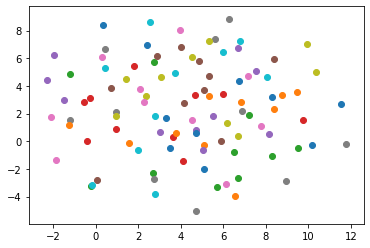

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


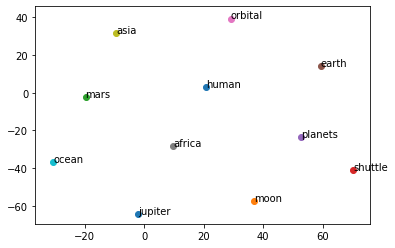

iter: 1 averaged cost = 0.18079455196857452
iter= 1 	 batch =  49 / 2790 	 cost =  9.12941837310791
Transforming number of word_embeddings  100 (100, 100)


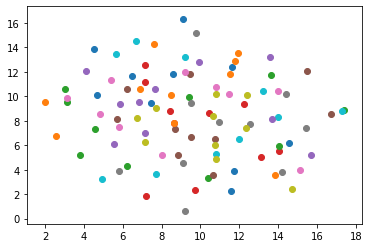

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


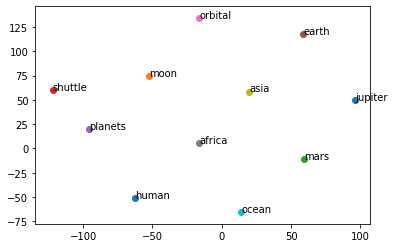

iter: 2 averaged cost = 0.16553401947021484
iter= 2 	 batch =  49 / 2790 	 cost =  8.259244918823242
Transforming number of word_embeddings  100 (100, 100)


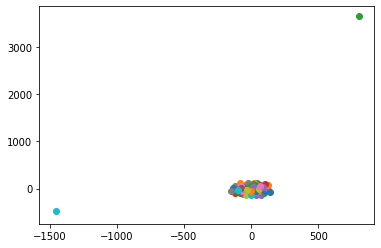

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


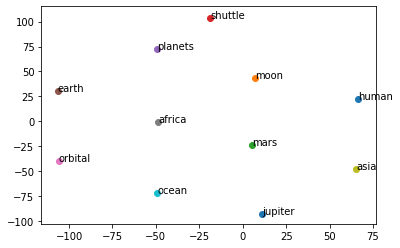

iter: 3 averaged cost = 0.14813268184661865
iter= 3 	 batch =  49 / 2790 	 cost =  7.359176158905029
Transforming number of word_embeddings  100 (100, 100)


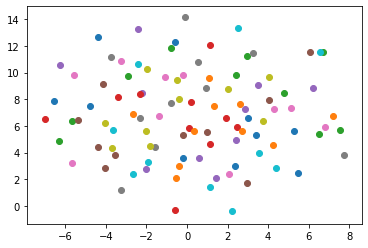

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


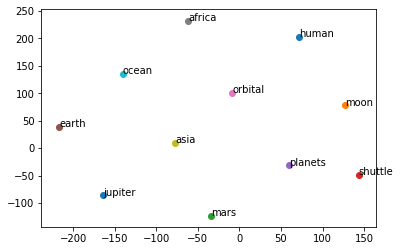

iter: 4 averaged cost = 0.12862803041934967
iter= 4 	 batch =  49 / 2790 	 cost =  6.610339164733887
Transforming number of word_embeddings  100 (100, 100)


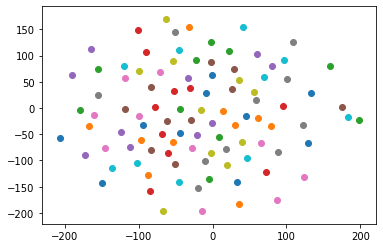

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


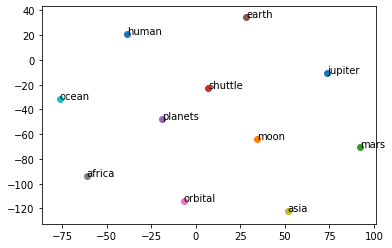

iter: 5 averaged cost = 0.11113100498914719
iter= 5 	 batch =  49 / 2790 	 cost =  6.040986061096191
Transforming number of word_embeddings  100 (100, 100)


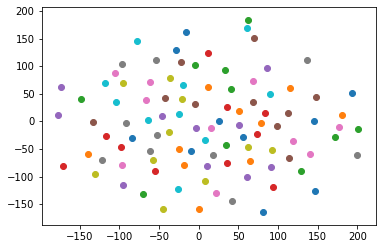

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


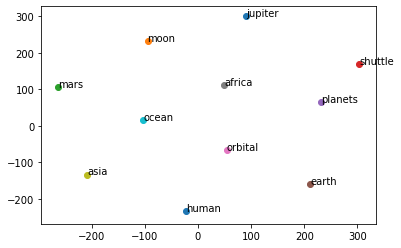

iter: 6 averaged cost = 0.09794113785028458
iter= 6 	 batch =  49 / 2790 	 cost =  5.6092000007629395
Transforming number of word_embeddings  100 (100, 100)


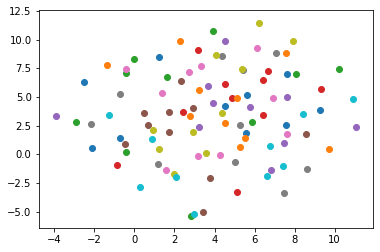

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


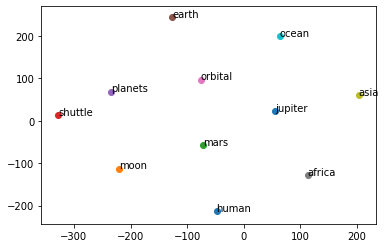

iter: 7 averaged cost = 0.08860398083925247
iter= 7 	 batch =  49 / 2790 	 cost =  5.275271415710449
Transforming number of word_embeddings  100 (100, 100)


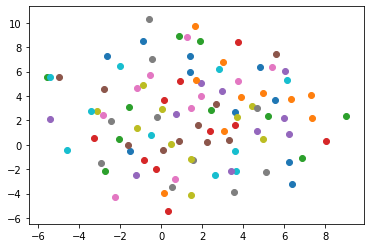

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


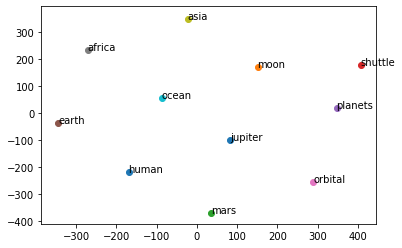

iter: 8 averaged cost = 0.081965371966362
iter= 8 	 batch =  49 / 2790 	 cost =  5.011864185333252
Transforming number of word_embeddings  100 (100, 100)


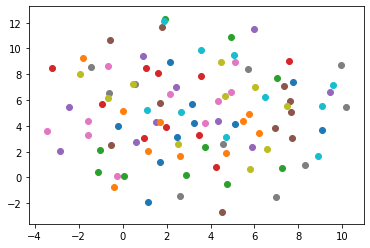

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


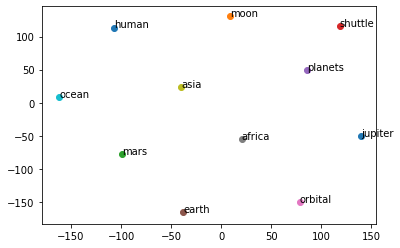

iter: 9 averaged cost = 0.07708413898944855
iter= 9 	 batch =  49 / 2790 	 cost =  4.799283027648926
Transforming number of word_embeddings  100 (100, 100)


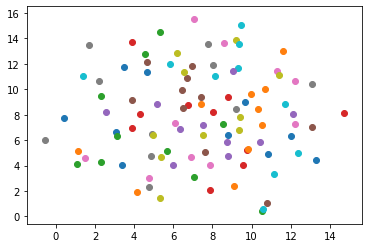

['jupiter', 'moon', 'mars', 'shuttle', 'planets', 'earth', 'orbital', 'africa', 'asia', 'ocean', 'human']


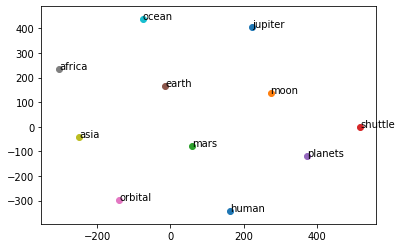

iter: 10 averaged cost = 0.0733419880270958
Learning Finished!


In [137]:
# Training the model!

#Self - Parameters
epochs = 10
show_it = 50


total_batch = len(batch_set)
cos_training = [] 

for iter in range(epochs):
    avg_cost = 0
    tar_list = []
    
    for i,(tar, con) in enumerate(batch_set):
        
        model.zero_grad()
        value = model(tar)

        cost = F.nll_loss(value,con)
#         cost = loss_function(value,con)
        
        if(type(tar_list) == list):
            tar_list = tar
        else:
            tar_list = torch.cat((tar_list,tar),0)
    
        cost.backward() 
        optimizer.step()
        
        avg_cost += cost.data / total_batch
        cos_training.append(cost.item())
        
        if ((i+1) % show_it ==0):
            print("iter=", iter ,"\t batch = ", i,"/",total_batch ,"\t cost = ", cos_training[-1])
            break
    
    plot_embed(tar_list)
    plot_special()
    print("iter:",iter + 1,"averaged cost =",avg_cost.item())

print('Learning Finished!')